1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Symptom-Based Severity Score: 36.51
Image-Based Severity Score: 2165.20
Final Severity Score: 1100.85
Severity Level: Moderate


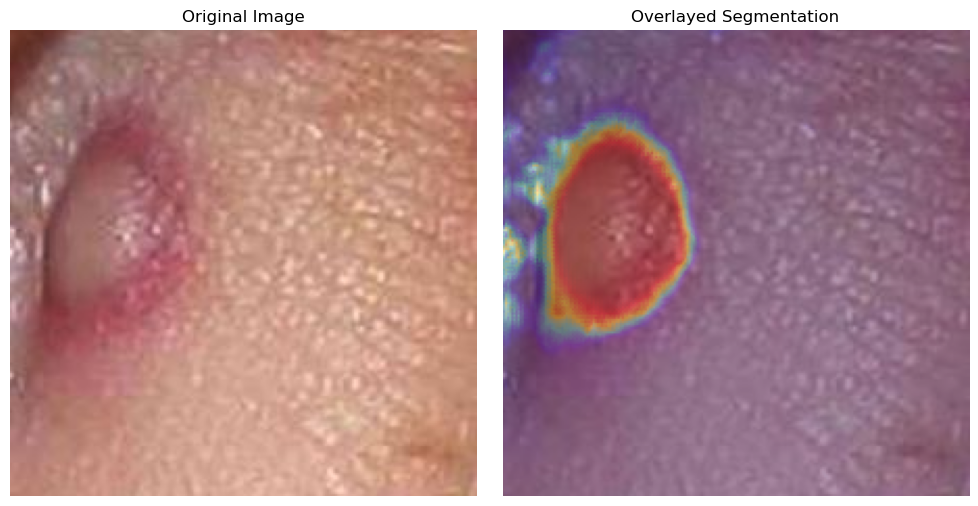

In [2]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load your pre-trained U-Net model with custom metrics
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights based on WHO guidelines
symptom_weights = {
    'Rectal Pain': 5,
    'Sore Throat': 4,
    'Penile Oedema': 6,
    'Oral Lesions': 7,
    'Solitary Lesion': 5,
    'Swollen Tonsils': 4,
    'HIV Infection': 8,
    'Sexually Transmitted Infection': 6,
    'Systemic Illness_Fever': 6,
    'Systemic Illness_Muscle Aches and Pain': 5,
    'Systemic Illness_Swollen Lymph Nodes': 7,
    'Systemic Illness_n/a': 0
}

# Severity thresholds for number of lesions
T1, T2, T3 = 5, 10, 17  # Updated severity thresholds
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100  # Maximum lesion and area values for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    
    # Cap the maximum lesions to 50
    num_lesions = min(num_labels - 1, 50)
    
    return total_lesion_area, num_lesions, lesion_sizes

# Function to calculate image severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    S_image = alpha * (num_lesions / N_max) + beta * (total_lesion_area / A_max)
    return S_image * 100

# Function to calculate final severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    return gamma * S_symptoms + delta * S_image

# Function to determine severity level
def determine_severity_level(S_final, num_lesions):
    if num_lesions < T1:
        return "Mild"
    elif T1 <= num_lesions <= T2:
        return "Moderate"
    elif T2 < num_lesions <= T3:
        return "Severe"
    else:  # num_lesions > T3
        return "Serious"

# Function to process patient data and visualize results
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, num_lesions)
    
    # Overlay the predicted mask on the original image
    overlayed_image = image.copy()
    mask_colored = cv2.applyColorMap((predicted_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(overlayed_image, 0.7, mask_colored, 0.3, 0)
    
    return S_symptoms, S_image, S_final, severity_level, overlayed_image

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_093.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size

# Process patient data
S_symptoms, S_image, S_final, severity_level, overlayed_image = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Symptom-Based Severity Score: 38.83
Image-Based Severity Score: 10.56
Final Severity Score: 24.70
Severity Level: Mild


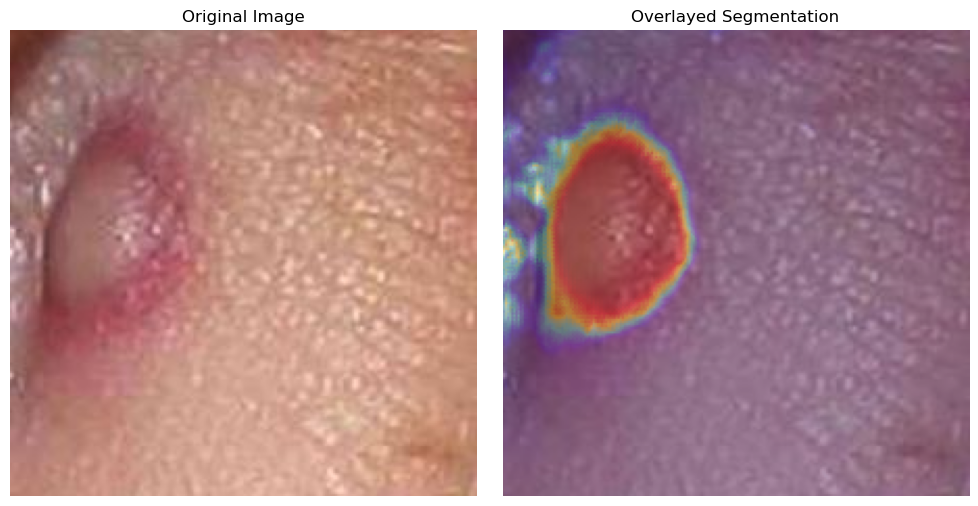

In [4]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds for final score
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000  # Maximum lesions and lesion area for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)  # Normalize and cap to 1.0
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)  # Normalize and cap to 1.0
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

# Function to process patient data and calculate severity
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    
    return S_symptoms, S_image, S_final, severity_level, predicted_mask

# Load pre-trained U-Net model
unet_model = load_model('best_unet_custom.keras')

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_093.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()
